In [26]:
from collections import defaultdict
import json
import pandas as pd
delimiters = [' ', ',', '.', ':', ';', '"', '\'']
def simple_tokenize(sentence): # takes a string and returns a list of tokens, removes punctuation whitespaces
	text = sentence
	tokens = []
	i = 0
	n = len(text)
	loctok = []
	while(i < n):
		if(text[i] in delimiters):
			tokens.append(''.join(loctok))
			loctok = []
			j = i
			while(j < n and text[j] in delimiters):
				j += 1
			i = j
		else: 
			loctok.append(text[i])
			i += 1
	if(loctok):
		tokens.append(''.join(loctok))
	return tokens
def word_tokenize(sentence):
	text = sentence
	tokens = []
	i = 0
	n = len(sentence)
	loctok = []
	while(i < n):
		if(text[i] in delimiters):
			if(loctok):
				loctok.append('_')
				tokens.append(''.join(loctok))
				loctok = []
			j = i
			while(j < n and text[j] in delimiters):
				j += 1
			i = j
		else: 
			loctok.append(text[i])
			i += 1
	if(loctok):
		tokens.append(''.join(loctok))
	return tokens
def test(path):
	df = pd.read_json(path, lines=True)
	print(df.head)
class my_tokenizer:
	def __init__(self, path, sz=10):
		self.tokens = set()
		df = pd.read_json(path, lines=True)
		# first half of the data
		n = len(df)
		sz = n // 2
		self.df = df[:sz]
		self.merges = []
	def get_sentences(self):
		sentences = []
		fields = ['title', 'abstract', 'doi', 'date']
		for index, row in self.df.iterrows():
			for field in fields:
				if field in row:
					sentences.append(str(row[field]))
		return sentences
	def simple_train(self):
		sentences = self.get_sentences()
		for sentence in sentences:
			tokens = simple_tokenize(sentence)
			for tok in tokens:
				self.tokens.add(tok)
		pass
	def bpe_train(self, k):
		sentences = self.get_sentences()
		# sentences = ['low low low low low lowest lowest newer newer newer newer newer newer wider wider wider new new ']
		word_freqs = defaultdict(int)
		for sentence in sentences:
			word_tokens = word_tokenize(sentence)
			for word in word_tokens:
				word_freqs[word] += 1

		# now build the base vocabulary
		# print(word_freqs)
		word_splits = {}
		base_vocabulary = set()
		for word in word_freqs.keys():
			for char in word:
				base_vocabulary.add(char)
			word_splits[word] = list(word)
		# print(base_vocabulary)
		merges = []
		while(len(merges) < k):
			pair_freqs = defaultdict(int)
			for word in word_freqs.keys():
				subword_tok_list = word_splits[word]
				n = len(subword_tok_list)
				if n == 1: continue
				for i in range(n - 1):
					pair = (subword_tok_list[i], subword_tok_list[i+1])
					pair_freqs[pair] += word_freqs[word]

			# as an optimization could map the pairs to the words they are in

			max_pair = None
			max_freq = 0
			for pair, freq in pair_freqs.items():
				if freq > max_freq:
					max_pair = pair
					max_freq = freq
			if(max_pair == None): break
			# max_pair = max(pair_freqs, key=pair_freqs.get)
			base_vocabulary.add(max_pair[0] + max_pair[1])
			merges.append(max_pair)
			for word in word_splits.keys():
				if len(word_splits[word]) == 1: continue
				i = 0 
				while i < len(word_splits[word]) - 1:
					subword_tok_list = word_splits[word]
					pair = (subword_tok_list[i], subword_tok_list[i+1])
					if pair == max_pair:
						new_word_splits = subword_tok_list[:i]
						new_word_splits.append(max_pair[0] + max_pair[1])
						new_word_splits.extend(subword_tok_list[i+2:])
						word_splits[word] = new_word_splits
					else: i += 1
			# get the most frequent pair
		print(len(merges))
		print(merges)
		self.tokens = base_vocabulary
		self.merges = merges

		# print(word_splits)
		# print(base_vocabulary)
	def write_vocabulary_bpe(self, path):
		vocab = {}
		for item in self.tokens:
			vocab[item] = 1
		output = {}
		output["merges"] = self.merges
		output["vocabulary"] = vocab
		output["type"] = "bpe"
		json.dump(output, open(path, 'w'))

In [27]:
import time
a = my_tokenizer("./train_data/cord19-trec_covid-docs")
t1 = time.time()
a.bpe_train(9)
print(f"time taken = {time.time() - t1}")

# word_tokenize("hello my name is John;doe")

9
[('e', '_'), ('s', '_'), ('i', 'n'), ('d', '_'), ('t', 'h'), ('t', 'i'), ('a', 'n'), ('o', 'n'), ('e', 'r')]
time taken = 43.80756115913391


In [28]:

a.write_vocabulary("vocab.json")
# t1 = time.time()
# a.bpe_train(18)
# print(f"time taken = {time.time() - t1}")

In [18]:
import matplotlib.pyplot as plt
k_tests = [10,20,30,40,50]
times = []
for k in k_tests:
	t1 = time.time()
	a.bpe_train(k)
	times.append(time.time() - t1)

10
[('e', '_'), ('s', '_'), ('i', 'n'), ('d', '_'), ('t', 'h'), ('t', 'i'), ('a', 'n'), ('o', 'n'), ('e', 'r'), ('e', 'n')]
20
[('e', '_'), ('s', '_'), ('i', 'n'), ('d', '_'), ('t', 'h'), ('t', 'i'), ('a', 'n'), ('o', 'n'), ('e', 'r'), ('e', 'n'), ('a', 'l'), ('r', 'e'), ('y', '_'), ('t', '_'), ('o', 'r'), ('e', 'd_'), ('o', 'f'), ('th', 'e_'), ('of', '_'), ('on', '_')]
30
[('e', '_'), ('s', '_'), ('i', 'n'), ('d', '_'), ('t', 'h'), ('t', 'i'), ('a', 'n'), ('o', 'n'), ('e', 'r'), ('e', 'n'), ('a', 'l'), ('r', 'e'), ('y', '_'), ('t', '_'), ('o', 'r'), ('e', 'd_'), ('o', 'f'), ('th', 'e_'), ('of', '_'), ('on', '_'), ('a', 'r'), ('i', 'c'), ('an', 'd_'), ('r', 'o'), ('a', 'ti'), ('a', 't'), ('al', '_'), ('g', '_'), ('s', 't'), ('in', '_')]
40
[('e', '_'), ('s', '_'), ('i', 'n'), ('d', '_'), ('t', 'h'), ('t', 'i'), ('a', 'n'), ('o', 'n'), ('e', 'r'), ('e', 'n'), ('a', 'l'), ('r', 'e'), ('y', '_'), ('t', '_'), ('o', 'r'), ('e', 'd_'), ('o', 'f'), ('th', 'e_'), ('of', '_'), ('on', '_'), ('a'

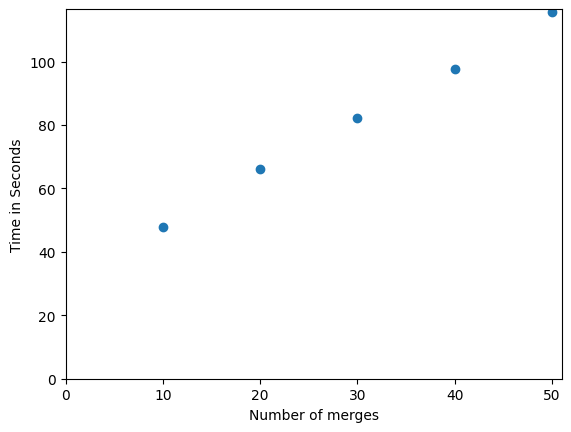

In [22]:
# plt.xlabel('Number of merges')
# plt.ylabel('Time in Seconds')
# plt.xlim(0, max(k_tests) + 1)
# plt.ylim(0, max(times) + 1)
# plt.scatter(k_tests, times)
# plt.savefig('bpe_time.png')